In [1]:
import pandas as pd
import geopandas as gpd
import pysal.lib as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline
import itertools

In [28]:
storm = pd.read_csv("C:/Users/Administrator/Desktop/788p/Natalie_project/Data/storm_data.csv")
storm

,# ---------------------------------- WARNING ----------------------------------------,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,# Some of the data that you have obtained from...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# may not have received Director's approval. A...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,# as provisional and are subject to revision. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,# condition that neither the USGS nor the Unit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,# for any damages resulting from its use.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
312,USGS,4230380,10/5/2021 22:45,EST,109,P,4.05,P,0,P
313,USGS,4230380,10/5/2021 23:00,EST,107,P,4.04,P,0,P
314,USGS,4230380,10/5/2021 23:15,EST,107,P,4.04,P,0,P
315,USGS,4230380,10/5/2021 23:30,EST,105,P,4.03,P,0,P


In [29]:
#Format data
storm.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28],axis=0,inplace=True)


In [30]:
storm.drop(['Unnamed: 5','Unnamed: 3','Unnamed: 7','Unnamed: 9'],axis=1,inplace=True)


In [31]:
storm.rename( columns={'Unnamed: 1':'Site_Number'}, inplace=True )
storm.rename( columns={'Unnamed: 2':'Date_Time'}, inplace=True )
storm.rename( columns={'Unnamed: 4':'Discharge'}, inplace=True )
storm.rename( columns={'Unnamed: 6':'Gage_Height'}, inplace=True )
storm.rename( columns={'Unnamed: 8':'Precip'}, inplace=True )
storm

,# ---------------------------------- WARNING ----------------------------------------,Site_Number,Date_Time,Discharge,Gage_Height,Precip
27,agency_cd,site_no,datetime,107605_00060,107606_00065,254536_00045
29,USGS,4230380,10/3/2021 0:00,12.5,3.21,0
30,USGS,4230380,10/3/2021 0:15,12.5,3.21,0
31,USGS,4230380,10/3/2021 0:30,12.1,3.2,0
32,USGS,4230380,10/3/2021 0:45,12.1,3.2,0
...,...,...,...,...,...,...
312,USGS,4230380,10/5/2021 22:45,109,4.05,0
313,USGS,4230380,10/5/2021 23:00,107,4.04,0
314,USGS,4230380,10/5/2021 23:15,107,4.04,0
315,USGS,4230380,10/5/2021 23:30,105,4.03,0


In [32]:
list(storm.columns)

['# ---------------------------------- WARNING ----------------------------------------',
 'Site_Number',
 'Date_Time',
 'Discharge',
 'Gage_Height',
 'Precip']

In [33]:
storm.drop('# ---------------------------------- WARNING ----------------------------------------', axis=1,inplace=True)

In [34]:
storm.drop(27,axis=0,inplace=True)
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip
29,4230380,10/3/2021 0:00,12.5,3.21,0
30,4230380,10/3/2021 0:15,12.5,3.21,0
31,4230380,10/3/2021 0:30,12.1,3.2,0
32,4230380,10/3/2021 0:45,12.1,3.2,0
33,4230380,10/3/2021 1:00,12.1,3.2,0
...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109,4.05,0
313,4230380,10/5/2021 23:00,107,4.04,0
314,4230380,10/5/2021 23:15,107,4.04,0
315,4230380,10/5/2021 23:30,105,4.03,0


In [35]:
baseflow = 12.1

In [36]:
storm['Discharge'] = storm['Discharge'].apply(lambda x: float(x))

In [37]:
#calculate runoff in cfs
storm['Runoff'] = storm['Discharge'] - baseflow

In [38]:
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip,Runoff
29,4230380,10/3/2021 0:00,12.5,3.21,0,0.4
30,4230380,10/3/2021 0:15,12.5,3.21,0,0.4
31,4230380,10/3/2021 0:30,12.1,3.2,0,0.0
32,4230380,10/3/2021 0:45,12.1,3.2,0,0.0
33,4230380,10/3/2021 1:00,12.1,3.2,0,0.0
...,...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109.0,4.05,0,96.9
313,4230380,10/5/2021 23:00,107.0,4.04,0,94.9
314,4230380,10/5/2021 23:15,107.0,4.04,0,94.9
315,4230380,10/5/2021 23:30,105.0,4.03,0,92.9


In [39]:
#how much time has passed since start of storm
storm['Cummulative_Time']= np.arange(0, 4320, 15)
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip,Runoff,Cummulative_Time
29,4230380,10/3/2021 0:00,12.5,3.21,0,0.4,0
30,4230380,10/3/2021 0:15,12.5,3.21,0,0.4,15
31,4230380,10/3/2021 0:30,12.1,3.2,0,0.0,30
32,4230380,10/3/2021 0:45,12.1,3.2,0,0.0,45
33,4230380,10/3/2021 1:00,12.1,3.2,0,0.0,60
...,...,...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109.0,4.05,0,96.9,4245
313,4230380,10/5/2021 23:00,107.0,4.04,0,94.9,4260
314,4230380,10/5/2021 23:15,107.0,4.04,0,94.9,4275
315,4230380,10/5/2021 23:30,105.0,4.03,0,92.9,4290


In [40]:
#Unit conversion from cfs to cubic feet per fifteen minutes
storm['Runoff_15'] = storm['Runoff']*60*15
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip,Runoff,Cummulative_Time,Runoff_15
29,4230380,10/3/2021 0:00,12.5,3.21,0,0.4,0,360.0
30,4230380,10/3/2021 0:15,12.5,3.21,0,0.4,15,360.0
31,4230380,10/3/2021 0:30,12.1,3.2,0,0.0,30,0.0
32,4230380,10/3/2021 0:45,12.1,3.2,0,0.0,45,0.0
33,4230380,10/3/2021 1:00,12.1,3.2,0,0.0,60,0.0
...,...,...,...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109.0,4.05,0,96.9,4245,87210.0
313,4230380,10/5/2021 23:00,107.0,4.04,0,94.9,4260,85410.0
314,4230380,10/5/2021 23:15,107.0,4.04,0,94.9,4275,85410.0
315,4230380,10/5/2021 23:30,105.0,4.03,0,92.9,4290,83610.0


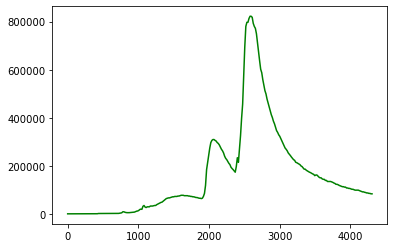

In [41]:
plt.plot(storm['Cummulative_Time'], storm['Runoff_15'], color = 'g')

In [42]:
cummulative_runoff = storm['Runoff_15']*4
N = 4
cr = cummulative_runoff.groupby(cummulative_runoff.index // N).sum()


In [43]:
#Calculate runoff velocity
#rainfall intensity/ hour
precipitation = storm['Precip']
precipitation = precipitation.apply(lambda x: float(x))
N = 4
rainfall_intensity = precipitation.groupby(precipitation.index // N).sum()
print(rainfall_intensity)

7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
     ... 
75    0.0
76    0.0
77    0.0
78    0.0
79    0.0
Name: Precip, Length: 73, dtype: float64


In [59]:
list_of_tuples = list(zip(rainfall_intensity, cr)) 
df = pd.DataFrame(list_of_tuples,
                  columns = ['Precipitation_per_hr', 'runoff_per_hr']) 

In [61]:
df.to_csv("C:/Users/Administrator/Desktop/788p/Natalie_project/Data/hourly.csv")

In [60]:
#rational method
drainage_basin_area = 39.5
c = .45

df['Precipitation_per_hr'] = df['Precipitation_per_hr'].apply(lambda x: float(x))

df['velocity_cf_per_hr'] = (df['Precipitation_per_hr'] * drainage_basin_area * c)*60*60

In [58]:
df

,Precipitation_per_hr,runoff_per_hr,velocity_cf_per_hr
0,0.0,2880.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1440.0,0.0
...,...,...,...
68,0.0,1582560.0,0.0
69,0.0,1510560.0,0.0
70,0.0,1431360.0,0.0
71,0.0,1366560.0,0.0
